In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import torch.nn as nn
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [2]:
data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//train_data.csv")

In [16]:
train_data, others_data = train_test_split(data, test_size=0.7, random_state=42)

In [17]:
train_X = train_data[['latitude', 'longitude']].values
train_y = train_data['temp'].values.reshape(-1, 1) 

# Convert to PyTorch Tensors
X_tensor = torch.tensor(train_X, dtype=torch.float32)
y_tensor = torch.tensor(train_y, dtype=torch.float32)

# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Batch size can be adjusted depending on your dataset size and memory
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)


In [18]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
# Create an instance of the model and optimizer
model = NN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss() 

In [20]:
best_val_loss = float('inf') 
save_path = 'C://dropout_MC//dropout_MC//_03_analyze//model//initial_model.pth' 
epochs = 1000

for epoch in range(epochs):
    # --- train ---
    model.train() 
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- evaluation ---
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    if (epoch + 1) % 100 == 0:
        print(f'epoch[{epoch+1}/{epochs}], eval: {avg_val_loss:.4f}')

    # --- best model save ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

print("training finished!")
print(f"best model was saved at {save_path}: eval loss: {best_val_loss:.4f})")

epoch[100/1000], eval: 16.0180
epoch[200/1000], eval: 25.0160
epoch[300/1000], eval: 27.1596
epoch[400/1000], eval: 33.9182
epoch[500/1000], eval: 27.0422
epoch[600/1000], eval: 12.9071
epoch[700/1000], eval: 22.4303
epoch[800/1000], eval: 11.6521
epoch[900/1000], eval: 12.6819
epoch[1000/1000], eval: 15.9110
training finished!
best model was saved at C://dropout_MC//dropout_MC//_03_analyze//model//initial_model.pth: eval loss: 6.9742)


In [21]:
loaded_model = NN()
loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [46]:
test_data = pd.read_csv("C://dropout_MC//dropout_MC//_02_build//data//test_data.csv")
test_X = train_X = test_data[['latitude', 'longitude']].values
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

In [47]:
y_pred = loaded_model(test_X_tensor).detach().numpy()

In [49]:
test_data["pred"] = y_pred

In [51]:
test_data.to_csv("C://dropout_MC//dropout_MC//_03_analyze//result//initial_model_pred.csv", index=False)

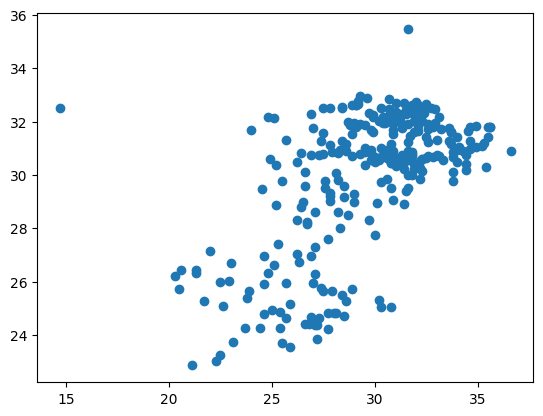

In [50]:
plt.scatter(test_data["temp"], test_data["pred"])